In [1]:
pwd

'/sdf/home/c/carsmith/flash_reconstruction/flash_detection'

In [3]:
import sys
sys.path.append('..')
from data_utils import *
from waveforms.make_waveform import BatchedLightSimulation

import torch
import numpy as np
import pickle
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Subset
import importlib
import wandb
import torch.optim as optim
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR
import matplotlib.gridspec as gridspec

import matplotlib.pyplot as plt

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if using CUDA

In [5]:
# Loading in data
load_wfs = np.load('official_train_100k.npy', allow_pickle=True) # array of shape (2519, 5, 250, 250)
dataset = WaveformDataset(load_wfs.item())

g = torch.Generator()
g.manual_seed(seed)

# Splitting data
val_ratio = 0.1
test_ratio = 0.0
total_size = len(dataset)
val_size = int(total_size * val_ratio)
test_size = int(total_size * test_ratio)
train_size = total_size - val_size - test_size
print(f"split sizes: {train_size, val_size, test_size}")
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=g)

batch_size = 25

def custom_collate_fn(batch):
    """
    Custom collate function for WaveformDataset.
    Each item in batch is a tuple: (waveform, arrival_time).
    Returns:
        waveforms: Tensor of shape (batch_size, waveform_length)
        arrival_times: Tensor of shape (batch_size,) or (batch_size, 1)
        hit_times: Tensor of shape (?) with a list of hit times per sample
    """
    waveforms, arrival_times, hit_times, photon_bins, photon_list = zip(*batch)
    waveforms = torch.stack(waveforms, dim=0)
    waveforms = waveforms.unsqueeze(1)  # adding channel dimension

    # for binary classification
    arrival_times = torch.stack(arrival_times, dim=0)
    arrival_times = arrival_times.unsqueeze(1) # adding channel dimension
    photon_bins = torch.stack(photon_bins, dim=0)
    photon_bins = photon_bins.unsqueeze(1)

    # for regression, just use hit times
    hit_times = [item[2] for item in batch]
    hit_times = torch.tensor(hit_times)
    photon_list = [item[4] for item in batch]
    photon_list = torch.tensor(photon_list)
    
    return waveforms, arrival_times, hit_times, photon_bins, photon_list
    

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    generator=g,
    collate_fn=custom_collate_fn,
    num_workers=0,
    pin_memory=False,
    drop_last=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=custom_collate_fn,
    num_workers=0,
    pin_memory=False,
    drop_last=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=custom_collate_fn,
    num_workers=0,
    pin_memory=False,
    drop_last=False
)

split sizes: (90000, 10000, 0)


In [6]:
waveforms, arrival_times, hit_times, photon_bins, photon_list = next(iter(train_loader))
print(hit_times[3].shape)

torch.Size([1])


hit_times: torch.Size([25, 1])
torch.Size([25, 1, 800])
torch.Size([25, 1, 800])


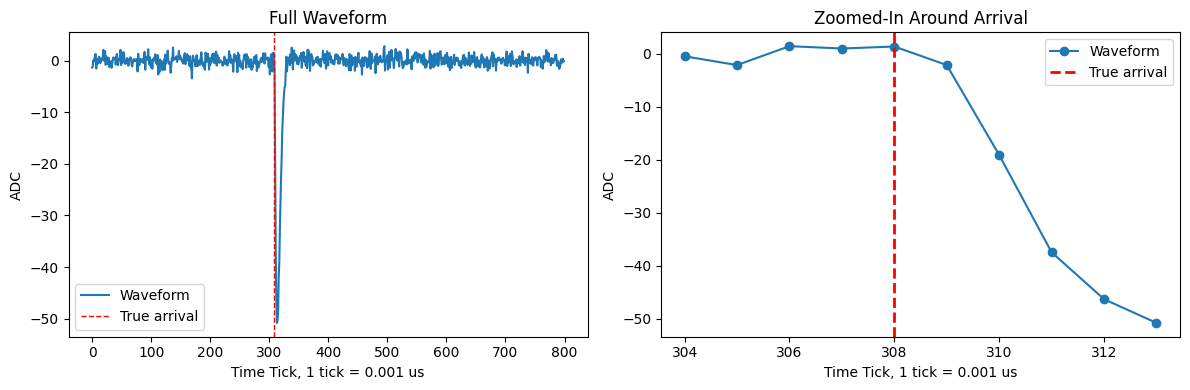

In [40]:
# Inspecting data
waveforms, arrival_times, hit_times, photon_bins, photon_list = next(iter(train_loader))
print(f"hit_times: {hit_times.shape}")
print(waveforms.shape)
print(arrival_times.shape)
ticks = np.arange(waveforms[0].shape[1])

# Create two horizontal subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# Select the first waveform and arrival
for i, wf in enumerate(waveforms):
    ticks = torch.arange(wf.shape[-1])  # assume ticks = [0, 1, ..., length-1]
    wf = wf.squeeze(0)  # shape: [length]
    arrival_idx = torch.nonzero(arrival_times[i].squeeze(0), as_tuple=False).squeeze().item()

    # First subplot: full waveform
    axs[0].plot(ticks, wf, alpha=1, label='Waveform')
    # axs[0].axvline(x=arrival_idx, color='r', linestyle='--', linewidth=2, label='True arrival')

    # FOR MULTIPLE HITS!
    for j, t in enumerate(hit_times[i]):
        axs[0].axvline(
            x=t.item(), 
            color='r', 
            linestyle='--', 
            linewidth=1, 
            label='True arrival' if j == 0 else ""
        )
    axs[0].set_title("Full Waveform")
    axs[0].set_xlabel(f"Time Tick, 1 tick = 0.001 us")
    axs[0].set_ylabel("ADC")
    axs[0].legend()

    # Second subplot: zoomed in around true arrival
    zoom_window = 5  # ±10 ticks = 20 total
    start = max(arrival_idx - zoom_window + 1, 0)
    end = min(arrival_idx + zoom_window + 1, wf.shape[0])

    axs[1].plot(ticks[start:end], wf[start:end], alpha=1, label='Waveform', marker = 'o')
    axs[1].axvline(x=arrival_idx, color='r', linestyle='--', linewidth=2, label='True arrival')
    axs[1].set_title("Zoomed-In Around Arrival")
    axs[1].set_xlabel(f"Time Tick, 1 tick = 0.001 us")
    axs[1].set_ylabel("ADC")
    axs[1].legend()

    break  # only do the first waveform

plt.tight_layout()
plt.show()

In [41]:
# Doing the training yuhh
from model import *
from utils import *
import torch.optim as optim
import wandb

epochs = 50
device = 'cuda'

# try tracking with wandb
logger = wandb.init(
    project="unet_smallamp_range_training",
    name="run1",
    config={
        "epochs": epochs,
        "batch_size": batch_size,
        "lr": 1e-4,
    }
)

model = UNet1D()
# model = TransformerModel()
model.to(device)
wandb.watch(model, log="all", log_freq=100)

criterion = torch.nn.BCEWithLogitsLoss() # combines sigmoid + loss
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

mode = 'mined_bce'
results = train_model_2(model, train_loader, val_loader, scheduler, optimizer, device, epochs, mode, logger)
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
}, "test.pth")

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: carsmith (carsmith-stanford-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [12]:
# Instantiating from a Checkpoint
# checkpoint = torch.load("test.pth", weights_only=True)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
# start_epoch = epochs + 1

# more_epochs = 10
# more_results = train_model_2(model, train_loader, val_loader, scheduler, optimizer, device, more_epochs, mode, logger)
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'scheduler_state_dict': scheduler.state_dict(),
# }, "test2.pth")

/lscratch/carsmith/tmp/ipykernel_3655221/499436496.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("test.pth")
                                  

In [31]:
# concatenate results
# dicts = [results, more_results, results_20]
# all_results = {k: np.concatenate([d[k] for d in dicts]) for k in dicts[0]}

# save results
with open('multiflash_30epochs_167samples.pkl', 'wb') as file:
    pickle.dump(all_results, file)

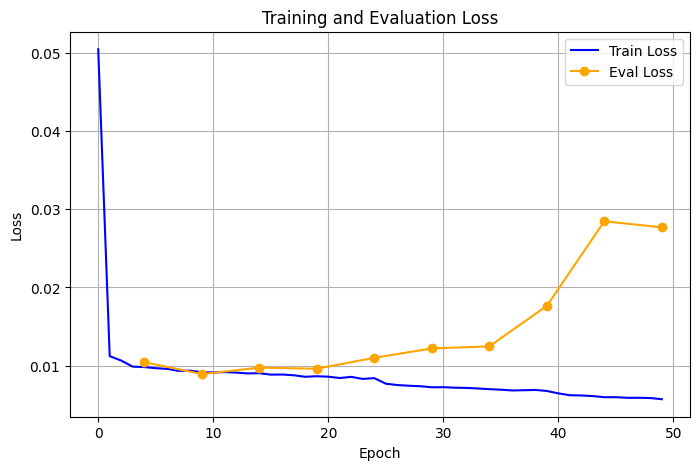

In [42]:
plt.figure(figsize=(8, 5))

# with open("precision_unet_80_results.pkl", "rb") as f:
#     all_results = pickle.load(f)
all_results = results

# Plot training loss (one per epoch)
plt.plot(all_results['train_loss'], label='Train Loss', color='blue')

# Plot eval loss (every 5 epochs)
eval_epochs = np.arange(0, len(all_results['train_loss']), 5)
plt.plot(eval_epochs + 4, all_results['eval_loss'], marker='o', label='Eval Loss', color='orange')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [28]:
# with open("all_results.pkl", "wb") as f:
#     pickle.dump(all_results, f)

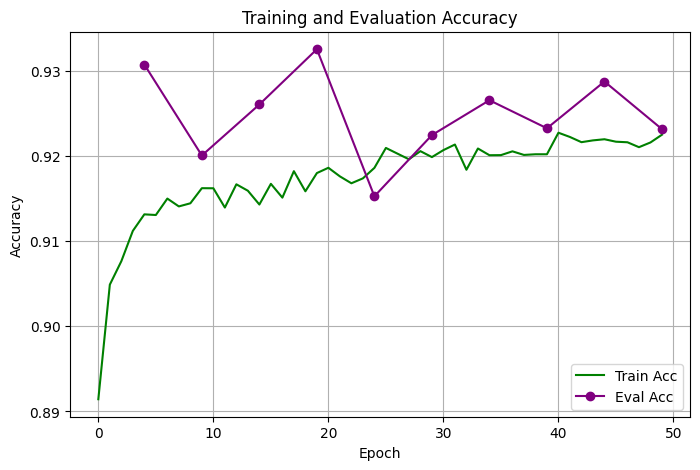

In [43]:
plt.figure(figsize=(8, 5))

# Plot training loss (one per epoch)
plt.plot(all_results['train_acc'], label='Train Acc', color='green')

# Plot eval loss (every 5 epochs)
eval_epochs = np.arange(0, len(all_results['train_acc']), 5)
plt.plot(eval_epochs + 4, all_results['eval_acc'], marker='o', label='Eval Acc', color='purple')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Evaluation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

### Inspecting BCE Loss with Negative Mining

In [19]:
train_progress = tqdm(val_loader, leave=False, position=0)
for i, (data, target, hit_times) in enumerate(train_progress):
    data, target, hit_times = data.to(device), target.to(device), hit_times.to(device) # model output is [25, 992] but target is [25, 1000] due to mismatch in downsampling/upsampling shapes
    output = model(data)
    print(output.shape)
    break
loss, sampled_indices, masked_target, masked_output, output, target = mined_bce_loss(data, hit_times, output, device)

torch.Size([25, 1, 800])


In [20]:
print(hit_times.shape)

torch.Size([25, 17])


In [21]:
print(len(sampled_indices[0]))
print(f"hit_times: {hit_times[0]}")
print(torch.where(target[0] == 1.0))
print(masked_output[:152])
print(masked_target[:152])
print(torch.nonzero(sampled_indices.cpu()[0] == True).tolist())

800
hit_times: tensor([  9.2328,  94.9247, 109.1331, 150.3285, 169.9195, 264.1297, 412.1293,
        469.0399, 505.6092, 507.5300, 520.0204, 534.8350, 541.4910, 547.0527,
        561.8275, 582.1076, 658.0793], device='cuda:0', dtype=torch.float64)
(tensor([109, 194, 209, 250, 269, 364, 512, 569, 605, 607, 620, 634, 641, 647,
        661, 682, 758], device='cuda:0'),)
tensor([-10.3068,  -7.0840, -11.2796, -12.2985, -13.7210, -13.7778, -12.5634,
        -11.6026, -11.5500, -11.5245, -10.7822, -11.1683,  -9.0663, -11.0497,
        -12.5405, -14.1120, -12.6468,  12.1316, -14.0842, -11.9758, -12.7100,
        -11.4404, -11.6612, -10.9664, -10.6644, -11.4043, -11.5881, -11.8616,
        -12.6890, -13.1048, -12.3827, -12.9520, -13.1050, -13.2433, -14.4698,
         -6.6107,   6.0822,   7.1520, -12.3740,  -4.5149,   7.9284, -12.6221,
        -11.9160, -11.9431, -15.0603,   9.5936,  -1.5766,  -6.1483, -11.7794,
        -13.1207,  -1.1197,   8.0103,   4.9293, -11.0976, -12.1058, -11.5499,
      

Hit times: [46, 70, 96, 105, 159, 167, 230, 316, 318, 333, 364, 390, 434, 442, 521, 533, 744]
Sampled indices: [4, 20, 26, 34, 37, 38, 39, 43, 44, 59, 60, 65, 77, 80, 83, 96, 98, 106, 111, 118, 124, 125, 128, 129, 131, 138, 139, 140, 146, 151, 152, 157, 158, 163, 168, 170, 176, 183, 191, 193, 195, 196, 204, 205, 207, 211, 218, 219, 220, 221, 224, 229, 232, 233, 236, 240, 250, 259, 267, 270, 271, 273, 285, 289, 291, 292, 298, 303, 304, 310, 313, 328, 330, 334, 337, 341, 343, 355, 356, 360, 364, 368, 372, 375, 376, 377, 378, 389, 391, 394, 406, 408, 410, 416, 418, 423, 426, 430, 433, 435, 438, 440, 442, 444, 447, 463, 464, 472, 473, 480, 484, 486, 488, 490, 492, 495, 501, 504, 517, 527, 533, 534, 537, 542, 545, 550, 554, 567, 573, 579, 581, 587, 597, 604, 608, 614, 621, 625, 631, 633, 634, 638, 640, 650, 654, 657, 662, 663, 664, 671, 689, 692, 693, 699, 708, 710, 719, 728, 736, 748, 755, 756, 774, 781, 786, 788, 799]
True hit indices within masked: [15, 80, 102, 120]


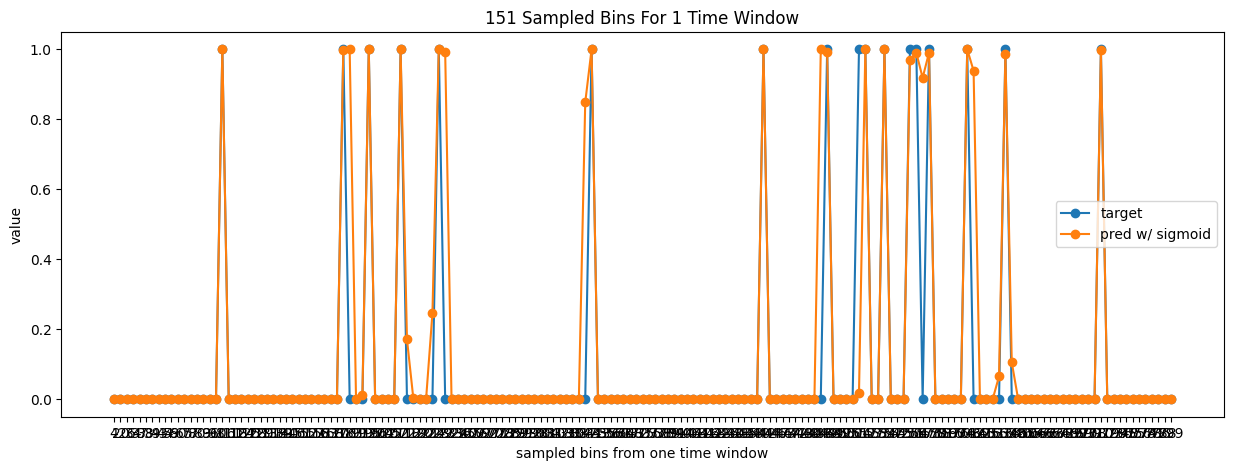

In [23]:
# Inspecting Sampled Bins
plt.figure(figsize=(15, 5))
plt.plot(masked_target[:167].cpu(), marker='o', label='target')
plt.plot(torch.sigmoid(masked_output[:167]).detach().cpu(), marker='o', label='pred w/ sigmoid')

hit_idx = hit_times[3].int()
mask = sampled_indices[3].cpu()
sampled_locs = torch.nonzero(mask).squeeze()
true_hit_locs_in_masked = [i for i, idx in enumerate(sampled_locs) if idx.item() in hit_idx.tolist()]

print("Hit times:", hit_idx.tolist())
print("Sampled indices:", sampled_locs.tolist())
print("True hit indices within masked:", true_hit_locs_in_masked)

# Step 5: Plot vertical lines at those true hit positions in the masked plot
# for i, true_idx in enumerate(true_hit_locs_in_masked):
#     plt.axvline(
#         x=true_idx, 
#         color='r', 
#         linestyle='--', 
#         linewidth=1, 
#         label='True arrival' if i == 0 else ""
#     )
# plt.axvline(true_idx, color='red', linestyle='--', linewidth=3, label='true hit')
# plt.axvspan(true_idx, true_idx+50, color='red', alpha=0.1, label='within 250 ns of hit')

indices = torch.nonzero(sampled_indices.cpu()[3] == True).squeeze().tolist()
plt.xticks(ticks=range(len(indices)), labels=indices)

plt.xlabel('sampled bins from one time window')
plt.ylabel('value')
plt.title('151 Sampled Bins For 1 Time Window')
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), "unet_5epochs.pth")

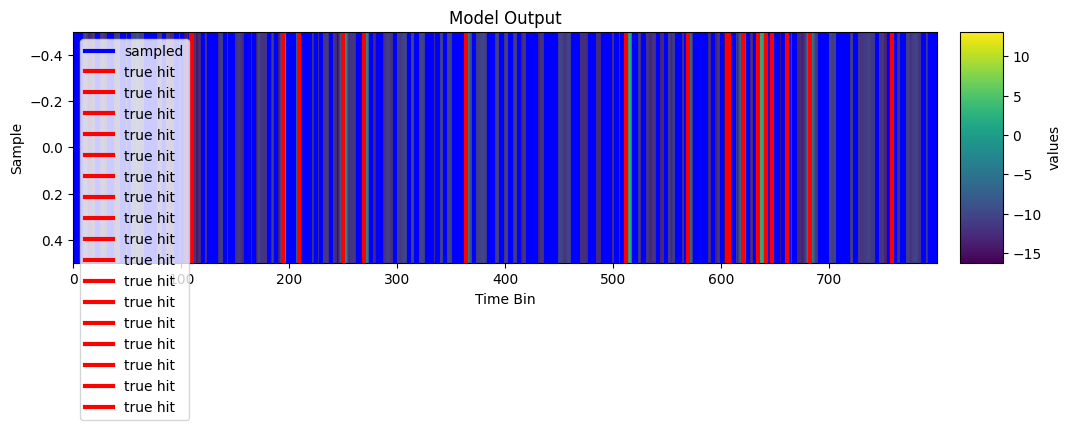

In [17]:
fig = plt.figure(figsize=(12, 3))
gs = gridspec.GridSpec(1, 2, width_ratios=[20, 1], wspace=0.05)  # allocate space

ax1 = fig.add_subplot(gs[0])
heatmap = output[0].detach().cpu().numpy()
im = ax1.imshow(heatmap, aspect='auto', cmap='viridis')

for i, idx in enumerate(sampled_indices[0].nonzero(as_tuple=True)[0].tolist()):
    if i == 10:
        ax1.axvline(idx, color='blue', linestyle='-', linewidth=3, label='sampled')
    else:
        ax1.axvline(idx, color='blue', linestyle='-', linewidth=3)

for idx in target[0].nonzero(as_tuple=True)[0].tolist():
    ax1.axvline(idx, color='red', linestyle='-', linewidth=3, label='true hit')

ax1.legend()
ax1.set_title("Model Output")
ax1.set_xlabel("Time Bin") 
ax1.set_ylabel("Sample")

# Add colorbar on the right
cax = fig.add_subplot(gs[1])  # colorbar axis
fig.colorbar(im, cax=cax, orientation='vertical', label='values')
plt.show()

In [ ]:
print(output[0].shape)
print(output[0, 5:10].shape)

### Inspecting Absolute delta t Accuracy Calculation

In [ ]:
train_progress = tqdm(train_loader, leave=False, position=0)
for i, (data, target, hit_times) in enumerate(train_progress):
    data, target, hit_times = data.to(device), target.to(device), hit_times.to(device) # data and target [B, 1, 16000], hit_times [B, 1]
    output = model(data)
    break

acc, output_batch, gt_indices_batch, pred_batch  = val_regression(data, hit_times, output, device)

In [ ]:
fig = plt.figure(figsize=(12, 3))
gs = gridspec.GridSpec(1, 2, width_ratios=[20, 1], wspace=0.05)  # allocate space

ax1 = fig.add_subplot(gs[0])
heatmap = output_batch.unsqueeze(0).detach().cpu().numpy()
im = ax1.imshow(heatmap, aspect='auto', cmap='viridis')

# Vertical lines at near-zero bins
for idx in gt_indices_batch:
    ax1.axvline(idx.cpu(), color='red', linestyle='--', linewidth=3, label='true hit')

for idx in pred_batch:
    ax1.axvline(idx.cpu(), color='pink', linestyle='--', linewidth=3, label='pred hit')
# Labels and title
ax1.legend()
ax1.set_title("Model Output")
ax1.set_xlabel("Time Bin") 
ax1.set_ylabel("Sample")

# Add colorbar on the right
cax = fig.add_subplot(gs[1])  # colorbar axis
fig.colorbar(im, cax=cax, orientation='vertical', label='values')
plt.show()

### Inspecting BCE Accuracy Calculation

In [ ]:
train_progress = tqdm(train_loader, leave=False, position=0)
for i, (data, target, hit_times) in enumerate(train_progress):
    data, target, hit_times = data.to(device), target.to(device), hit_times.to(device) # data and target [B, 1, 16000], hit_times [B, 1]
    output = model(data)
    break

acc, data_batch, output_batch, true_indices, topk_set  = val_bce(data, hit_times, output, device)

In [ ]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 3))
gs = gridspec.GridSpec(1, 2, width_ratios=[20, 1], wspace=0.05)  # allocate space

ax1 = fig.add_subplot(gs[0])
heatmap = output_batch.unsqueeze(0).detach().cpu().numpy()
im = ax1.imshow(heatmap, aspect='auto', cmap='viridis')

# Vertical lines at near-zero bins
for idx in true_indices:
    ax1.axvline(idx, color='red', linestyle='--', linewidth=3, label='true hit')

for idx in topk_set:
    ax1.axvline(idx, color='pink', linestyle='--', linewidth=3, label='pred hit')
# Labels and title
ax1.legend()
ax1.set_title("Model Output: Logits")
ax1.set_xlabel("Time Bin") 
ax1.set_ylabel("Sample")

# Add colorbar on the right
cax = fig.add_subplot(gs[1])  # colorbar axis
fig.colorbar(im, cax=cax, orientation='vertical', label='logit value')
plt.show()

### Regression Loss: Inspecting Targets

In [ ]:
from loss import *
# regression - calculate delta t from each bin center to precise flash arrival time
train_progress = tqdm(train_loader, leave=False, position=0)
for i, (data, target, hit_times) in enumerate(train_progress):
    data, target, hit_times = data.to(device), target.to(device), hit_times.to(device) # data and target [B, 1, 16000], hit_times [B, 1]
    output = model(data)
    break

# Get model output and target diffs for the batch
with torch.no_grad():
    # output: [B, 1, 16000]
    output = model(data, mode='regression')
    _, target_diffs = regression_loss_fast(data, hit_times, output, device, strategy='closest')
    output = model(data, mode='regression').squeeze(1).detach().cpu()  # [B, 16000]
target_diffs = target_diffs.cpu() # [B, 16000]
print(target_diffs.shape)

########################## Comparing output & target absolute times ########################
# N = min(2, output.shape[0])  # Show up to 2 samples
# fig, axes = plt.subplots(N, 2, figsize=(14, 2*N), sharex=True, sharey=True)

# if N == 1:
#     axes = axes.reshape(1, 2)

# for i in range(N):
#     # Model output subplot
#     out = output[i].unsqueeze(0).cpu().numpy()
#     im0 = axes[i, 0].imshow(out, aspect='auto', cmap='viridis')
#     axes[i, 0].set_ylabel(f"Sample {i}")
#     axes[i, 0].set_title("Model Output (delta t)")

#     # Target subplot
#     tgt = target_diffs[i].cpu().numpy()
#     im1 = axes[i, 1].imshow(tgt, aspect='auto', cmap='viridis')
#     axes[i, 1].set_title("Target delta t")

# # Add colorbars
# fig.colorbar(im0, ax=axes[:, 0], orientation='vertical', fraction=0.02)
# fig.colorbar(im1, ax=axes[:, 1], orientation='vertical', fraction=0.02)

# plt.suptitle("Model Output vs Target Time Differences (delta t) Heatmaps", fontsize=16)
# plt.tight_layout(rect=[0, 0, 1, 0.97])
# plt.show()
############################################################################################

# fig, ax = plt.subplots(figsize=(9, 8))   # increase height
# diffs_np = diffs.cpu().numpy()
# im = ax.imshow(diffs_np, aspect='auto', interpolation='nearest')
# zero_locs = np.argwhere(diffs_np < 1.0)
# for (y, x) in zero_locs:
#     ax.scatter(x, y, marker='s', color='red')#, markersize=4, markeredgewidth=0.5)
# plt.colorbar(im, ax=ax)
# plt.show()

In [ ]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 3))
gs = gridspec.GridSpec(1, 2, width_ratios=[20, 1], wspace=0.05)  # allocate space

ax1 = fig.add_subplot(gs[0])
heatmap = target_diffs[0].unsqueeze(0).cpu().numpy()
im = ax1.imshow(heatmap, aspect='auto', cmap='viridis')

# Overlay waveform
ax2 = ax1.twinx()
waveform = data[0].squeeze().cpu().numpy()
ax2.plot(waveform, color='white', alpha=0.7, linewidth=1)
ax2.set_ylabel("Waveform Amplitude", color='white')
ax2.tick_params(axis='y', labelcolor='white')

# Vertical lines at near-zero bins
zero_bins = np.where(np.isclose(heatmap[0], 0, atol=1e-1))[0]
for zb in zero_bins:
    ax1.axvline(zb, color='red', linestyle='--', linewidth=4, label='hit time')

# Labels and title
ax1.legend()
ax1.set_title("Target: Absolute delta t Heatmap")
ax1.set_xlabel("Time Bin")
ax1.set_ylabel("Sample")

# Add colorbar on the right
cax = fig.add_subplot(gs[1])  # colorbar axis
fig.colorbar(im, cax=cax, orientation='vertical', label='absolute delta t')
plt.show()

### BCE Loss: Inspecting Objective

In [ ]:
with torch.no_grad():
    # output: [B, 1, 16000]
    output = model(data, mode='bce')  # [B, 16000]
    loss, target_classes = bce_loss(data, hit_times, output, device)

target_classes = target_classes.cpu() # [B, 16000]
print(target_classes.shape)

fig = plt.figure(figsize=(12, 3))
gs = gridspec.GridSpec(1, 2, width_ratios=[20, 1], wspace=0.05)  # allocate space
ax1 = fig.add_subplot(gs[0])
heatmap = target_classes[0].unsqueeze(0).cpu().numpy()
im = ax1.imshow(heatmap, aspect='auto', cmap='viridis')

# Overlay waveform
ax2 = ax1.twinx()
waveform = data[0].squeeze().cpu().numpy()
ax2.plot(waveform, color='white', alpha=0.7, linewidth=1)
ax2.set_ylabel("Waveform Amplitude", color='white')
ax2.tick_params(axis='y', labelcolor='white')

# Vertical lines at near-zero bins
pos_bins = np.where(np.isclose(heatmap[0], 1, atol=1e-1))[0]
for zb in pos_bins:
    ax1.axvline(zb, color='yellow', linestyle='-', linewidth=4, label='hit time')

# Labels and title
ax1.legend()
ax1.set_title("Target: Per-Bin Classes")
ax1.set_xlabel("Time Bin")
ax1.set_ylabel("Sample")

# Add colorbar on the right
cax = fig.add_subplot(gs[1])  # colorbar axis
# fig.colorbar(im, cax=cax, orientation='vertical', label='absolute delta t')
cbar = fig.colorbar(im, cax=cax, orientation='vertical', label='Per-Bin Class')
cbar.set_ticks([0.0, 1.0])
cbar.set_ticklabels(['no hit', 'yes hit'])

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

ticks = np.arange(len(results['train_loss']))  # assuming 1 value per epoch

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# --- Plot 1: Training Loss ---
axes[0].plot(ticks, results['train_loss'], label='Train Loss')
axes[0].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[0].set_xlabel("Epochs", fontsize=12)
axes[0].set_ylabel("Loss", fontsize=12)
axes[0].set_title("Training Loss", fontsize=14, fontweight='bold')
axes[0].legend()

# --- Plot 2: Training Accuracy ---
axes[1].plot(ticks, results['train_acc'], label='Train Accuracy', color='green')
axes[1].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[1].set_xlabel("Epochs", fontsize=12)
axes[1].set_ylabel("Accuracy", fontsize=12)
axes[1].set_title("Training Accuracy", fontsize=14, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
import importlib
import utils
importlib.reload(utils)
test_data, test_target, test_loss, test_acc = test_model(model, test_loader, criterion, device)

In [ ]:
print(test_loss)
print(test_acc)
print((torch.argmax(pred, dim=-1) == torch.argmax(target, dim=-1)).sum().item())
print(len(test_loader.dataset))

In [ ]:
print(pred.shape) # shape is [B, 1] where for each batch there are 
# print(pred)
print(target[0]) # Item 1
print(torch.argmax(target))

test_progress = tqdm(test_loader, desc=f"Test Epoch {1}", leave=False, position=1)
for test_data, test_target in test_progress:
    test_data, test_target = test_data.to(device), test_target.to(device)
    test_output = model(test_data)
    arrival_indices = test_target.argmax(dim=1, keepdim=True)  # shape [B, 1]
    # arrival_indices = torch.argmax(test_target, dim=-1, keepdim=True)
    # print(arrival_indices)
    pred = test_output.gather(1, arrival_indices)  # shape [B, 1]
    target = test_target.gather(1, arrival_indices)  # shape [B, 1]

    print(torch.argmax(pred, dim=-1))
    print(torch.argmax(target, dim=-1))
    break

In [ ]:
import matplotlib.pyplot as plt

num_waveforms = 12
fig, axes = plt.subplots(3, 4, figsize=(20, 10), sharex=False, sharey=True)
axes = axes.flatten()

for i in range(num_waveforms):
    ax = axes[i]
    waveform = test_data[i].cpu().numpy().squeeze()
    ax.plot(waveform, label='Waveform')
    # Plot true start (green) and predicted start (red)
    pred_start = pred[i].squeeze(0).argmax().item()
    true_start = torch.nonzero(target[i].squeeze(0), as_tuple=False).squeeze().item()
    ax.axvline(true_start, color='g', linestyle='--', label='True Start' if i == 0 else "")
    ax.axvline(pred_start, color='r', linestyle='-', label='Pred Start' if i == 0 else "")
    ax.set_title(f'Waveform {i+1}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')
    ax.set_xticks(np.linspace(0, len(waveform)-1, 5, dtype=int))
    ax.set_yticks(np.linspace(waveform.min(), waveform.max(), 5))
    ax.tick_params(axis='y', which='both', labelleft=True)

    if i == 0:
        ax.legend()

plt.tight_layout()
plt.suptitle("Test Waveforms & Pred/True Start Times", fontsize=16, y=1.02)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

num_waveforms = 12
fig, axes = plt.subplots(3, 4, figsize=(20, 10), sharex=False, sharey=True)
axes = axes.flatten()

for i in range(num_waveforms):
    ax = axes[i]
    waveform = train_data[i].cpu().numpy().squeeze()
    ax.plot(waveform, label='Waveform')
    # Plot true start (green) and predicted start (red)
    pred_start = pred[i].squeeze(0).argmax().item()
    true_start = torch.nonzero(target[i].squeeze(0), as_tuple=False).squeeze().item()
    ax.axvline(true_start, color='g', linestyle='--', label='True Start' if i == 0 else "")
    ax.axvline(pred_start, color='r', linestyle='-', label='Pred Start' if i == 0 else "")
    ax.set_title(f'Waveform {i+1}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')
    ax.set_xticks(np.linspace(0, len(waveform)-1, 5, dtype=int))
    ax.set_yticks(np.linspace(waveform.min(), waveform.max(), 5))
    ax.tick_params(axis='y', which='both', labelleft=True)

    if i == 0:
        ax.legend()

plt.tight_layout()
plt.suptitle("Test Waveforms & Pred/True Start Times", fontsize=16, y=1.02)
plt.show()

In [ ]:
from model import *
from utils import *
import torch.optim as optim
import wandb

device = 'cuda'

model2 = UNet1D()
model2.to(device)
criterion = torch.nn.BCEWithLogitsLoss()
test_data2, test_target2, pred2, target2, test_loss2, avg_delta2 = test_model(model2, test_loader, criterion, device)

num_waveforms = 12
fig, axes = plt.subplots(3, 4, figsize=(20, 10), sharex=False, sharey=True)
axes = axes.flatten()

for i in range(num_waveforms):
    ax = axes[i]
    waveform = test_data2[i].cpu().numpy().squeeze()
    ax.plot(waveform, label='Waveform')
    # Plot true start (green) and predicted start (red)
    pred_start2 = pred2[i].squeeze(0).argmax().item()
    true_start2 = torch.nonzero(target2[i].squeeze(0), as_tuple=False).squeeze().item()
    ax.axvline(true_start2, color='g', linestyle='--', label='True Start' if i == 0 else "")
    ax.axvline(pred_start2, color='r', linestyle='-', label='Pred Start' if i == 0 else "")
    ax.set_title(f'Waveform {i+1}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')
    ax.set_xticks(np.linspace(0, len(waveform)-1, 5, dtype=int))
    ax.set_yticks(np.linspace(waveform.min(), waveform.max(), 5))
    ax.tick_params(axis='y', which='both', labelleft=True)

    if i == 0:
        ax.legend()

plt.tight_layout()
plt.suptitle("Test Waveforms & Pred/True Start Times", fontsize=16, y=1.02)
plt.show()